## Conditional Search Spaces with Hyperopt

In this notebooks, we will create a conditional (or nested) hyperparameter space to optimize the hyperparameters of 3 different off-the-shelf algorithms.

Utilizing the breast cancer dataset, we will optimize the hyperparameters for a linear regression, a random forest and a gradient boosting machine within the same search.

By the end of the search, we will know:

- which algorithm returns the best results
- which are the best hyperparameters for said algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import anneal

In [3]:
# load dataset

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = y.map({0:1, 1:0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

target
0    0.627417
1    0.372583
Name: count, dtype: float64

In [5]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the Hyperparameter Space

- [Hyperopt search space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

We need to define 3 spaces, 1 for each algorithm, nested or conditional to the algorithm. We create all this spaces in a master configuration.

In [6]:
# ==================================
# determine the hyperparameter space
# ==================================

# we create dictionaries with 2 keys: "model" and "params"
# in "model" we specify the algorithm, in "params", we pass
# a dictionary with the space for that particular algorithm

# important: pass the model as class and not
# instantiated, thus LogisticRegression istead of
# LogisticRegression()

# within the params dictionaries, the keys should be
# the parameter names of the algos, as per their 
# documentation

# within the hp in each dictionary, give different names to
# later on identify to which model was the hyperparameter assigned
# see for example n_estimators_rf and n_estimators_gbm later


# the nested space
param_grid = hp.choice('classifier', [
    
    # algo 1
    {'model': LogisticRegression,
    'params': {
        'penalty': hp.choice('penalty', ['l1','l2']),
        'C' : hp.uniform('C', 0.001, 10),
        'solver': 'saga', # the only solver that works with both penalties
    }},
    
    # algo 2
    {'model': RandomForestClassifier,
    'params': {
        'n_estimators': hp.quniform('n_estimators_rf', 50, 1500, 50),
        'max_depth': hp.quniform('max_depth_rf', 1, 5, 1),
        'criterion': hp.choice('criterion_rf', ['gini', 'entropy']),
    }},
    
    # algo 3
    {'model': GradientBoostingClassifier,
    'params': {
        'n_estimators': hp.quniform('n_estimators_gbm', 50, 1500, 50),
        'max_depth': hp.quniform('max_depth_gbm', 1, 5, 1),
        'criterion': hp.choice('criterion_gbm', ['friedman_mse', 'squared_error']),
    }},
])

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [7]:
def objective(params):
    
    # instantiate the model
    model = params['model']() # don't forget the () to instantiate the class
    
    # capture the sampled hyperparameters
    hyperparams = params['params']
        
    try:        
        # for tree based algorithms
        hyperparams['n_estimators'] = int(hyperparams['n_estimators'])
        hyperparams['max_depth'] = int(hyperparams['max_depth'])
    except:
        pass        
        
    # in case you want to visualize what is being sampled:
    print(model, hyperparams)

    # pass the parameters to the model
    model.set_params(**hyperparams)

    # train with cv
    cross_val_data = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='accuracy',
        cv=3,
        n_jobs=4,
    )

    # to minimize, we negate the score
    loss = -cross_val_data.mean()
    print(loss)
    print()
    
    return loss

In [8]:
# fmin performs the minimization
# anneal.suggest samples the parameters

trials = Trials()

anneal_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=anneal.suggest,  # annealing search
    trials=trials
)

LogisticRegression()                                                                                                   
{'C': 6.201569857768734, 'penalty': 'l2', 'solver': 'saga'}                                                            
-0.9120148856990963                                                                                                    
LogisticRegression()                                                                                                   
{'C': 4.430037069625402, 'penalty': 'l1', 'solver': 'saga'}                                                            
-0.9120148856990963                                                                                                    
LogisticRegression()                                                                                                   
{'C': 9.550139269380772, 'penalty': 'l2', 'solver': 'saga'}                                                            
-0.9120148856990963                     

-0.9573175362649047                                                                                                    
RandomForestClassifier()                                                                                               
{'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 850}                                                          
-0.9397357028935976                                                                                                    
GradientBoostingClassifier()                                                                                           
{'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 1050}                                                   
-0.9723551302498671                                                                                                    
GradientBoostingClassifier()                                                                                           
{'criterion': 'squared_error', 'max_dept

{'criterion': 'friedman_mse', 'max_depth': 2, 'n_estimators': 800}                                                     
-0.9598238019290651                                                                                                    
GradientBoostingClassifier()                                                                                           
{'criterion': 'friedman_mse', 'max_depth': 1, 'n_estimators': 850}                                                     
-0.9723551302498671                                                                                                    
GradientBoostingClassifier()                                                                                           
{'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 900}                                                    
-0.9723551302498671                                                                                                    
GradientBoostingClassifier()            

In [9]:
anneal_search

{'classifier': 2,
 'criterion_gbm': 1,
 'max_depth_gbm': 1.0,
 'n_estimators_gbm': 1050.0}

In [10]:
trials.argmin

{'classifier': 2,
 'criterion_gbm': 1,
 'max_depth_gbm': 1.0,
 'n_estimators_gbm': 1050.0}

In [11]:
trials.average_best_error()

-0.9723551302498671

In [12]:
trials.best_trial

{'state': 2,
 'tid': 24,
 'spec': None,
 'result': {'loss': -0.9723551302498671, 'status': 'ok'},
 'misc': {'tid': 24,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'C': [],
   'classifier': [24],
   'criterion_gbm': [24],
   'criterion_rf': [],
   'max_depth_gbm': [24],
   'max_depth_rf': [],
   'n_estimators_gbm': [24],
   'n_estimators_rf': [],
   'penalty': []},
  'vals': {'C': [],
   'classifier': [2],
   'criterion_gbm': [1],
   'criterion_rf': [],
   'max_depth_gbm': [1.0],
   'max_depth_rf': [],
   'n_estimators_gbm': [1050.0],
   'n_estimators_rf': [],
   'penalty': []}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 9, 19, 7, 30, 19, 271000),
 'refresh_time': datetime.datetime(2024, 9, 19, 7, 30, 29, 139000)}

<Axes: >

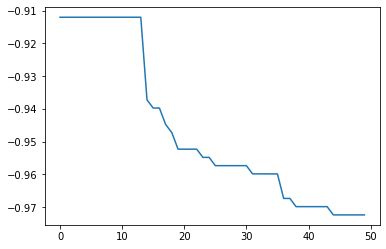

In [13]:
# convergence

pd.Series(trials.losses()).sort_values(ascending=False).reset_index(drop=True).plot()